In [ ]:
#https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
# from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [49]:
data=pd.read_csv("NSE-TATA.csv")
data.loc[:, 'Date'] = pd.to_datetime(data['Date'],format='%Y/%m/%d')
data.sort_values(by='Date', inplace=True, ascending=True)
n=10
df=pd.DataFrame(index=range(0,len(data)-n),columns=['Date', 'ROC'])
for i in range(n, len(data)):
    df["Date"][i-n]=data["Date"][i]
    df["ROC"][i-n]=(data["Close"][i] - data["Close"][i-n])/data["Close"][i-n]*100
df.sort_values(by='Date', inplace=True, ascending=True)

df.head()

,Date,ROC
1224,2013-10-08 00:00:00,-1.858268
1223,2013-10-09 00:00:00,-5.983681
1222,2013-10-10 00:00:00,-2.258163
1221,2013-10-11 00:00:00,-1.960184
1220,2013-10-14 00:00:00,-1.816502


In [50]:
df['EMA_9'] = df['ROC'].ewm(9).mean().shift()
df['SMA_5'] = df['ROC'].rolling(5).mean().shift()
df['SMA_10'] = df['ROC'].rolling(10).mean().shift()
df['SMA_15'] = df['ROC'].rolling(15).mean().shift()
df['SMA_30'] = df['ROC'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.ROC, name='ROC', opacity=0.2))
fig.show()

In [51]:
def relative_strength_idx(df, n=14):
    roc = df['ROC']
    delta = roc.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [52]:
EMA_12 = pd.Series(df['ROC'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['ROC'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.ROC, name='ROC'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [53]:
df['ROC'] = df['ROC'].shift(-1)

In [54]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [55]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.ROC, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.ROC, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.ROC,  name='Test'))
fig.show()

In [56]:
drop_cols = ['Date']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)
train_df.head()

,ROC,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,-1.326531,2.238433,-1.931304,-0.217748,4.650370,3.431673,19.542073,-1.838002,-1.274147
1,0.613288,1.872154,-1.889261,-1.109446,3.411507,3.452930,20.638791,-1.834454,-1.399689
2,2.583534,1.544073,-2.127086,-1.897046,2.302547,3.469262,26.925826,-1.664682,-1.457668
3,4.078076,1.448849,-1.595291,-1.608829,1.419892,3.630109,32.626256,-1.363893,-1.437529
4,1.416235,1.564666,-0.476669,-1.018038,0.720007,3.756877,42.965974,-0.999503,-1.344827


In [57]:
y_train = train_df['ROC'].copy()
X_train = train_df.drop(['ROC'], 1)

y_valid = valid_df['ROC'].copy()
X_valid = valid_df.drop(['ROC'], 1)

y_test  = test_df['ROC'].copy()
X_test  = test_df.drop(['ROC'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        834 non-null    float64
 1   SMA_5        834 non-null    float64
 2   SMA_10       834 non-null    float64
 3   SMA_15       834 non-null    float64
 4   SMA_30       834 non-null    float64
 5   RSI          834 non-null    float64
 6   MACD         834 non-null    float64
 7   MACD_signal  834 non-null    float64
dtypes: float64(8)
memory usage: 52.2 KB


In [ ]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
# model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)

clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

In [58]:
%%time
model_seed = 10
n_estimators = 300
max_depth = 12
learning_rate = 0.05
min_child_weight = 1
gamma = 0.001
model= xgb.XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight,
                      gamma=gamma,
                      objective='reg:squarederror')
# model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train)

Wall time: 2.01 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=10,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

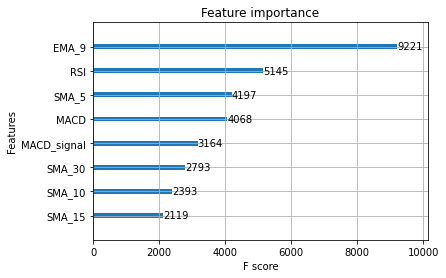

In [60]:
plot_importance(model);

In [59]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')


y_true = [-0.7494817413490743 2.2262236045179282 1.4918112534457486
 2.8330904970050184 2.6367187500000075]
y_pred = [1.2387265 0.65825   0.7774082 0.8377689 6.4247794]


In [60]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 17.122140383052987


In [61]:
model.save_model("model_xgBoost_ROC.h5")

In [62]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['ROC'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.ROC,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.ROC,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()